<a href="https://www.kaggle.com/code/emigiupponi/usdt-ranking-prices-in-argentina?scriptVersionId=155050911" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Ranking of the final prices -including commissions- of the principal brokers or exchanges of interest in pesos in Argentina

In [1]:
import requests
from datetime import date, datetime, timedelta
import pandas as pd

In [2]:
response = requests.get('https://criptoya.com/api/usdt/ars')
print(response)

<Response [200]>


In [3]:
json = response.json()
df = pd.DataFrame(json)

In [4]:
# Trasformación y cálculos intermedios
df_transposed = df.T
df_transposed.columns = ['Buying', 'Buying (final)', 'Selling', 'Selling (final)', 'Timestamp']

# Filtrar filas donde Buying (final) y Selling (final) no sean 0
df_transposed = df_transposed[(df_transposed["Buying (final)"] != 0) & (df_transposed["Selling (final)"] != 0)]

# Calcular el Spread y el Average daily price solo para las filas no filtradas
df_transposed['Spread'] = df_transposed["Buying (final)"] - df_transposed["Selling (final)"]
df_transposed['Average daily price'] = (df_transposed['Buying (final)'] + df_transposed['Selling (final)']) / 2

In [5]:
# Calcular el average para todo el sistema de cada columna y agregarlo como una nueva fila
average = df_transposed.mean().to_frame().T
average.index = ['average']
df_transposed = pd.concat([df_transposed, average])

In [6]:
df_transposed = df_transposed .sort_values('Spread', ascending=False)

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [8]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from datetime import date

# Crear subplots y definir el tamaño de la cuadrícula del gráfico
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('Prices', 'Spread'), 
               row_width=[0.2, 0.7])

# Obtener la fecha actual
current_date = date.today().strftime("%d %b %Y")

# Actualizar el diseño del gráfico
fig.update_layout(
    title=f'<b>USDT prices and spread in ARS for {current_date}<b>',
    title_font_color="#AA322F",
    scene=dict(
        xaxis_title='Date',
    ),
    margin=dict(l=50, r=50, b=50, t=50),
    font=dict(family='Segoe UI', size=11, color='#404040'), # Ajusta la fuente aquí
    paper_bgcolor='white', # Cambia el fondo del gráfico a blanco para un aspecto más formal
)

# Agregar nombres a los ejes Y
fig.update_yaxes(title_text='ARS', row=1, col=1)
fig.update_yaxes(title_text='ARS', row=2, col=1)

# Agregar trazas para 'Compra' y 'Venta' en tonos azules y grises
fig.add_trace(
    go.Scatter(x=df_transposed.index, y=df_transposed['Selling (final)'], name='Venta', line=dict(color='#6CADE1')), # Azul
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_transposed.index, y=df_transposed['Buying (final)'], name='Compra', line=dict(color='#1C598A')), # Azul claro
    row=1, col=1
)

# Agregar trazas para 'Spread %' en gris y establecer el color rojo para 'average'
colors = ['gray' if exchange != 'average' else '#AA322F' for exchange in df_transposed.index]
fig.add_trace(
    go.Bar(x=df_transposed.index, y=df_transposed['Spread'], name='Spread %', marker_color=colors),
    row=2, col=1
)

# Ocultar el rango deslizante de la gráfica OHLC
fig.update(layout_xaxis_rangeslider_visible=False)

# Mostrar el gráfico
fig.show()

<Figure size 800x600 with 0 Axes>

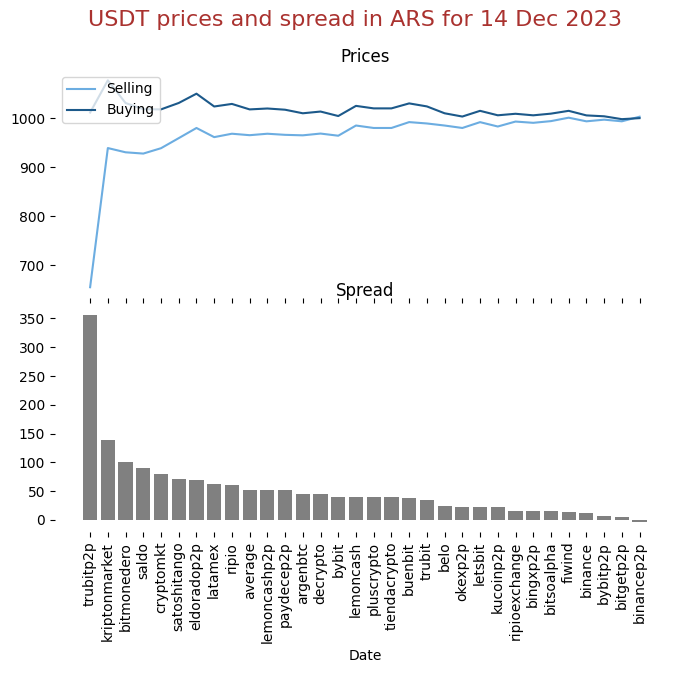

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date

# Define el tamaño de la figura en pulgadas
fig_day_static = plt.figure(figsize=(8, 6))

# Crea subtramas y especifica el tamaño de la cuadrícula del gráfico
fig_day_static, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))
fig_day_static.subplots_adjust(hspace=0.03)
fig_day_static.suptitle(f"USDT prices and spread in ARS for {current_date}", fontsize=16, color='#AA322F')

# Obtén la fecha actual
current_date = date.today().strftime("%d %b %Y")
# Obtén la fecha actual
current_date = date.today().strftime("%d %b %Y")

# Configura las subtramas y el fondo del gráfico
axes[0].set_title('Prices', fontsize=12)
axes[1].set_title('Spread', fontsize=12)
fig_day_static.patch.set_facecolor('white')

# Gráfico OHLC en la primera subtrama
axes[0].plot(df_transposed.index, df_transposed['Selling (final)'], label='Selling', color='#6CADE1')
axes[0].plot(df_transposed.index, df_transposed['Buying (final)'], label='Buying', color='#1C598A')

# Gráfico de barras para los volúmenes en la segunda subtrama
axes[1].bar(df_transposed.index, df_transposed['Spread'], color='gray')

# Personaliza los ejes
for ax in axes:
    ax.set_xlabel('Date')
    ax.get_xaxis().set_visible(True)  # No mostrar el eje X
    ax.grid(False)  # Eliminar las grillas
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Rotar los nombres de la segunda subtrama verticalmente
axes[1].tick_params(axis='x', rotation=90)

# Añade una leyenda
axes[0].legend(loc='upper left')

# Guarda el gráfico como un archivo PDF
plt.savefig("usdt_prices.pdf", format="pdf")

# Muestra el gráfico
plt.show()


# Times series data

Guardar los datos de hoy en un csv local

In [10]:
# crear el archivo csv con la fecha de ejecución del día a partri de la consulta api de arriba
from datetime import date

# Obtén la fecha actual
today = date.today()

# Convierte la fecha en una cadena en el formato deseado (por ejemplo, '2023-09-13')
date_str = today.strftime("%Y-%m-%d")

# Guarda el DataFrame con el nombre de la fecha
df_transposed.to_csv(f'{date_str}_data.csv', index=True)

Expotar a s3

In [11]:
# expotar el archivo a s3
import boto3
from botocore.exceptions import NoCredentialsError
from kaggle_secrets import UserSecretsClient

# Obtén las claves de acceso a AWS desde los secretos de Kaggle
user_secrets = UserSecretsClient()
aws_access_key_id = user_secrets.get_secret("AWSAccessKeyId")
aws_secret_access_key = user_secrets.get_secret("AWSSecretKey")

# Nombre del archivo y del bucket
file_name = f'{date_str}_data.csv'
bucket_name = "usdt-prices-arg"

# Crea un cliente de S3
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# Intenta crear el bucket
try:
    s3.create_bucket(Bucket=bucket_name)
except Exception as e:
    print(f'Error al crear el bucket: {e}')

# Sube el archivo al bucket de S3
try:
    s3.upload_file(file_name, bucket_name, file_name)
    print(f'{file_name} subido exitosamente a {bucket_name}')
except FileNotFoundError:
    print(f'El archivo {file_name} no se encontró')
except NoCredentialsError:
    print('No se encontraron credenciales de AWS')
except Exception as e:
    print(f'Error al subir el archivo a S3: {e}')

2023-12-14_data.csv subido exitosamente a usdt-prices-arg


Importar desde s3

In [12]:
# Listar los archivos en el bucket de S3:

# Nombre del bucket
bucket_name = "usdt-prices-arg"

# Crea un cliente de S3
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# Lista todos los objetos en el bucket
objects = s3.list_objects(Bucket=bucket_name)

# Extrae los nombres de archivo de la lista de objetos
file_names = [obj['Key'] for obj in objects['Contents']]

In [13]:
# Descargar los archivos desde S3

# NOTA: los primeros días tenían una columna promedio que decía deyli o algo así, para generar
# la base primero hacemos que el nombre esté ok, porque sino genera dos columnas en lugar de una

# Crear un DataFrame vacío para almacenar los datos
combined_df = pd.DataFrame()

# Recorre los nombres de archivo y descárgalos desde S3
for file_name in file_names:
    # Descarga el archivo desde S3
    s3.download_file(bucket_name, file_name, file_name)
    
    # Lee el archivo en un DataFrame
    df = pd.read_csv(file_name)
    
    # Renombra la columna si es necesario
    if "Average dayly price" in df.columns:
        df.rename(columns={"Average dayly price": "Average daily price"}, inplace=True)
    
    # Combina el DataFrame descargado con el DataFrame principal
    combined_df = pd.concat([combined_df, df], ignore_index=True)


In [14]:
# Función para convertir timestamp a fecha
def timestamp_to_date(timestamp):
    return pd.to_datetime(timestamp, unit='s').strftime("%d %b %Y")

# Aplica la función a la columna "Timestamp" y crea una nueva columna "Fecha"
combined_df['Fecha'] = combined_df['Timestamp'].apply(timestamp_to_date)

In [15]:
# solo por el primer día (porque quedó diferente)
# Reemplazar 'promedio' por 'average' en la columna 'Unnamed: 0'
combined_df['Unnamed: 0'] = combined_df['Unnamed: 0'].replace('promedio', 'average')

In [16]:
# Exportar el DataFrame a un archivo CSV en Kaggle
combined_df.to_csv('/kaggle/working/combined_df.csv', index=False)

In [17]:
import plotly.graph_objects as go

fig_3d = go.Figure()

# Ordenar los exchanges en función del último precio promedio de manera descendente
exchange_order = combined_df.groupby('Unnamed: 0')['Fecha'].max().sort_values(ascending=False).index

for exchange in exchange_order:
    data = combined_df[combined_df['Unnamed: 0'] == exchange]
    
    color = 'lightgrey'  # Color predeterminado para todas las series
    opacity = 0.1  # Opacidad predeterminada para las series en gris
    
    if exchange == 'average':
        color = 'darkred'  # Color para la serie 'average'
        opacity = 1  # La serie 'average' no será transparente
    
    fig_3d.add_trace(go.Scatter3d(
        x=data['Fecha'],  # Invertir el orden de las fechas
        y=[exchange] * len(data),
        z=data['Average daily price'],
        mode='lines+markers',
        name=exchange,
        marker=dict(
            size=3,  # Ajusta el tamaño de los marcadores
            symbol='circle',  # Cambia el símbolo según la serie
            color=color,  # Asigna el color correspondiente
            opacity=opacity  # Ajusta la opacidad
        ),
        line=dict(width=2)
    ))

fig_3d.update_layout(
    scene=dict(xaxis_title='', yaxis_title='', zaxis_title='ARS'),
    title=f'<b>Average Daily Values by Date and Exchange<b>',
    title_font_color="#AA322F",
)

fig_3d.show()

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import date

# Obtener la fecha actual
current_date = date.today().strftime("%d %b %Y")

# Define una paleta de colores personalizada
colores = {
    'average': "#AA322F",   # Bordó para 'average'
    'otro_nombre': 'rgb(128,128,128)',  # Gris para otros 'Unnamed: 0'
    'buying': '#1C598A',    # Azul oscuro para 'Buying (final)'
    'spread': 'gray'        # Gris para 'Spread'
}

# Calcular el spread relativo como porcentaje sobre la serie de "Average daily price"
combined_df['Spread Relative'] = (combined_df['Spread'] / combined_df['Average daily price']) * 100

# Create subplots
fig3 = make_subplots(rows=1, cols=2, shared_xaxes=True)

# Upper subplot: Buying (final) and Selling (final) Prices for 'average'
exchange = 'average'
show_legend = True

# Agrega la traza de Buying (final) con color azul oscuro
fig3.add_trace(go.Scatter(x=combined_df[combined_df['Unnamed: 0'] == exchange]['Fecha'], y=combined_df[combined_df['Unnamed: 0'] == exchange]['Buying (final)'], name='Buying (final)', mode='lines', line=dict(width=2, color=colores['buying']), showlegend=show_legend), row=1, col=1)

# Agrega la traza de Selling (final) con color bordó
fig3.add_trace(go.Scatter(x=combined_df[combined_df['Unnamed: 0'] == exchange]['Fecha'], y=combined_df[combined_df['Unnamed: 0'] == exchange]['Selling (final)'], name='Selling (final)', mode='lines', line=dict(width=2, color=colores['average']), showlegend=show_legend), row=1, col=1)

# Lower subplot: Spread Relative sobre la serie de "Average daily price" con color gris
fig3.add_trace(go.Scatter(x=combined_df[combined_df['Unnamed: 0'] == exchange]['Fecha'], y=combined_df[combined_df['Unnamed: 0'] == exchange]['Spread Relative'], name='Spread Relative', mode='lines', line=dict(width=2, color=colores['spread']), showlegend=False), row=1, col=2)

# Configure graph layout
fig3.update_layout(
    title=f'<b>Average USDT Prices and Relative Spread in ARS<b>',
    title_font_color="#AA322F",
    yaxis=dict(
        title='ARS',
        title_standoff=25,
        title_font=dict(size=18),
        tickformat='~s'
    ),
    yaxis2=dict(
        title='Spread %',
        title_standoff=25,
        title_font=dict(size=18),
        tickformat='~s',
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(0,0,0,0)',
        itemsizing='constant'
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    showlegend=True
)

# Show interactive graph
fig3.show()


# Sending to dashboard

In [19]:
pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import chart_studio
import chart_studio.plotly as py

In [21]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_3 = user_secrets.get_secret("CHARTSTUDIO_BCRA_API_KEY")

In [22]:
chart_studio.tools.set_credentials_file(username='crypto-financial-stability-monitor', 
                                        api_key=secret_value_3)
py.plot(fig, filename = 'arg-usdt-prices', auto_open=True)

'https://plotly.com/~crypto-financial-stability-monitor/634/'

In [23]:
py.plot(fig3, filename = 'arg-prices-usdt-times-series', auto_open=True)

'https://plotly.com/~crypto-financial-stability-monitor/743/'

In [24]:
py.plot(fig_3d, filename = 'arg-usdt-prices-3d', auto_open=True)

'https://plotly.com/~crypto-financial-stability-monitor/745/'